In [1]:
# Importing all important  libraries 
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf

#from tensorflow import WarmStartSettings
#Helper libraries
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
import os 
from random import randint
import pandas as pd
import numpy as np

import numpy as np
from sklearn.manifold import TSNE


LOG_DIR= "/home/rutujamoharil/Desktop/cardiacsearc_logs_jupyter/mnist_autoencoder_triplet_32"

# Loading data and splitting dataset
mnist_data=keras.datasets.fashion_mnist
(train_data, train_labels), (test_data, test_labels) = mnist_data.load_data()
print(train_data[0].shape)
print(test_data[0].shape)
print(len(train_data))
#Data standardization to get values pixel between 0 and 1 
train_data = train_data/ np.float32(255)

test_data= test_data / np.float32(255)

Using TensorFlow backend.


(28, 28)
(28, 28)
60000


# Define an autoencoder model for encoding upto size 32 

Autoencoder network for image reconstruction is used . This is a convolutional network and we want our encoding layer to go upto size 32 . 
Note : The encoding layer is compressed image representation and we want the weights to be in it .Thus activation function should not be applied to this layer .
So in this case the encoded layer is like a fully connected layer 

In [2]:
def cnn_model_fn(features,labels):

  strides=[2,2]

###########################

#Encoding layers 

  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  #labels=tf.reshape(labels,[-1,28,28,1])

  conv1 = tf.layers.conv2d(input_layer,32, (3, 3), activation=tf.nn.relu, padding='same',name='convolution_1')
  pool1 = tf.layers.max_pooling2d(conv1,(2, 2),strides=strides, padding='same')
  
  conv2 = tf.layers.conv2d(pool1,16, (3, 3), activation=tf.nn.relu, padding='same',name='convolution_2')

  pool2 = tf.layers.max_pooling2d(conv2,(2, 2), strides=strides,padding='same',name='pooling_2')
 
  conv3 = tf.layers.conv2d(pool2,8, (3, 3), activation=tf.nn.relu, padding='same',name='convolution_3')
  pool3 = tf.layers.max_pooling2d(conv3,(2, 2),strides=strides, padding='same',name='pooling_3') # Encoded is the latent vector 

  conv4 = tf.layers.conv2d(pool3,8,(3,3),activation=tf.nn.relu,padding='same',name='convolutional_4_8')
  pool4 = tf.layers.max_pooling2d(conv4,2,strides=[2,2], padding='same',name='pooling_4_8')
  print(pool4.shape)
  encoded = tf.layers.conv2d(pool4,8,(3,3),padding='same',name='latent_8')


## Decoding layers

  conv5 = tf.layers.conv2d(encoded,8, (3, 3), activation=tf.nn.relu, padding='same',name='convolutional_transpose_1_8')
  print("conv5" ,conv5.shape)
  conv6=tf.layers.Conv2DTranspose(8,2,strides=(2,2),padding='valid',name='upsample_8')(conv5)
  print("conv6" , conv6.shape)

  conv7 = tf.layers.conv2d(conv6,8, (3, 3), activation=tf.nn.relu, padding='same',name='convolutional_transpose_2')
  print("conv7",conv7.shape)
  conv8=tf.layers.Conv2DTranspose(8,4,strides=(1,1),padding='valid',name='upsample_2')(conv7)
  print("conv8" , conv8.shape)  

  conv11 = tf.layers.conv2d(conv8,16, (3, 3), activation='relu',padding='same',name='convolutional_transpose_3')
  conv12=tf.layers.Conv2DTranspose(16,2,strides=(2,2),padding='same',name='upsample_3')(conv11)
  print("conv12" , conv12.shape)  
    
  conv13= tf.layers.conv2d(conv12,32, (3, 3), activation='relu',padding='same',name='convolutional_transpose_4')
  conv14 =tf.layers.Conv2DTranspose(32,2,strides=(2,2),padding='same',name='upsample_4')(conv13)
  print(conv14.shape)

  decoded =tf.layers.conv2d(conv14,1, (3, 3), padding='same',name='decoded')
  print(decoded.shape)

  return decoded,encoded


# Estimator API for training 

Estimators are a high-level TensorFlow API that greatly simplifies machine learning programming. Estimators encapsulate the following actions:
training
evaluation
prediction
export for serving

Initially they are a bit tricky to understand, but definitely eases the process of training and logging the summaries.

In [3]:
def create_estimator(features, labels, mode):
    # Here labels is same as the features .Since we are reconstructing the same image ,the target variable is same 
    # as the input feature .Do not pass the class labels .    

    decoded, encoded= cnn_model_fn(features, labels)
    encoded = tf.identity(encoded, name="encoded")
    out_probability = tf.nn.relu(decoded)

    features = tf.reshape(features, [-1, 28, 28, 1])
    
    prediction_dict = {
        "image": features

    }
    predictions = {
        # "classes": tf.argmax(input=decoded, axis=1),
        "prob": out_probability
    }

    # Prediction mode

    if mode == tf.estimator.ModeKeys.PREDICT:
        export_outputs = {
            'prediction': tf.estimator.export.PredictOutput(
                decoded
            )
        }
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=prediction_dict, export_outputs=export_outputs)

    # Calculate Loss (for both TRAIN and EVAL modes)
    mse_loss = tf.losses.mean_squared_error(decoded,features)
    #triplet_loss= tf.contrib.losses.metric_learning.triplet_semihard_loss(labels,encoded,margin=1.0)
    
    ##### Logging summaries for Tensorboard (Abinaya method) ####################

    evaluation_summaries = []
    evaluation_summaries.append(tf.summary.image('input_images', features, max_outputs=6))
    evaluation_summaries.append(tf.summary.image('decoded_images', decoded, max_outputs=6))
    cosine_distance = tf.metrics.mean_cosine_distance(features, decoded, dim=0)
    metrics = {'cosine_distance': cosine_distance}
    evaluation_summaries.append(tf.summary.scalar('cosine_distance', cosine_distance[1]))
    #cross_entropy_loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=latent)
    encoded = tf.reshape(encoded, [-1, 32])
    labels = tf.cast(labels, tf.int32)
    
    print(labels.dtype,encoded.dtype)
    encoded_norm = tf.norm(encoded,ord='euclidean',axis = 1,keepdims = True)
    triplet = tf.contrib.losses.metric_learning.triplet_semihard_loss(labels,
                                                                      encoded/encoded_norm, margin=1.0)
    triplet_loss = tf.reduce_mean(triplet, name="triplet")
    evaluation_summaries.append(tf.summary.scalar('triplet_loss', triplet_loss))

    loss =  triplet_loss + mse_loss
            
    logging_hook = tf.train.LoggingTensorHook(
        {"step": tf.train.get_or_create_global_step(),
         "cosine_distance": cosine_distance[1],
         "loss": loss},
        every_n_iter=1,
        formatter=lambda d: "Step=%06d, Cosine Distance=%.8f, Loss=%.6f" % (
            d['step'], d['cosine_distance'], d['loss']))
    evaluation_hooks = [logging_hook]

    if mode == tf.estimator.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            optimizer="Adam",
            learning_rate=0.001,
            global_step=tf.train.get_global_step()
        )

    else:
        train_op = None
        evaluation_hooks.append(tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=LOG_DIR,
            summary_op=tf.summary.merge(evaluation_summaries)
        ))

    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=metrics, predictions=predictions,
        training_hooks=[logging_hook], train_op=train_op,
        
        evaluation_hooks=evaluation_hooks)


In [4]:
mnist_classifier = tf.estimator.Estimator(model_fn=create_estimator,model_dir=LOG_DIR,warm_start_from=None)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_data,
    y=train_labels,
    batch_size=100,
    num_epochs=5,
    shuffle=True)

# training the model 
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1001)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/rutujamoharil/Desktop/cardiacsearc_logs_jupyter/mnist_autoencoder_triplet_32', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f05925c5358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
(?, 2, 2, 8)
(?, 2, 2, 8)
conv5 (?, 2, 2, 8)
conv6 (?, 4, 4, 8)
conv7 (?, 4, 4, 8)
conv8 (?, 7, 7, 8)
conv12 (?, 14, 14, 16)
(?, 28, 28, 32)
(?, 28, 28, 1)
<dtype: 'int32'> <dtype: 'float32'>
INFO:tensorflow:Done calling

INFO:tensorflow:Step=000096, Cosine Distance=-10.51278400, Loss=0.526017
INFO:tensorflow:Step=000097, Cosine Distance=-10.52483845, Loss=0.517396
INFO:tensorflow:Step=000098, Cosine Distance=-10.54105854, Loss=0.496509
INFO:tensorflow:Step=000099, Cosine Distance=-10.57065582, Loss=0.502753
INFO:tensorflow:Step=000100, Cosine Distance=-10.59611320, Loss=0.483569
INFO:tensorflow:global_step/sec: 4.7985
INFO:tensorflow:loss = 0.3984341, step = 101 (20.841 sec)
INFO:tensorflow:Step=000101, Cosine Distance=-10.63937569, Loss=0.398434
INFO:tensorflow:Step=000102, Cosine Distance=-10.67959976, Loss=0.421739
INFO:tensorflow:Step=000103, Cosine Distance=-10.70642662, Loss=0.505740
INFO:tensorflow:Step=000104, Cosine Distance=-10.72232246, Loss=0.433464
INFO:tensorflow:Step=000105, Cosine Distance=-10.73753834, Loss=0.419545
INFO:tensorflow:Step=000106, Cosine Distance=-10.74881744, Loss=0.355305
INFO:tensorflow:Step=000107, Cosine Distance=-10.78304958, Loss=0.520571
INFO:tensorflow:Step=00010

INFO:tensorflow:Step=000206, Cosine Distance=-12.38224411, Loss=0.201625
INFO:tensorflow:Step=000207, Cosine Distance=-12.39906693, Loss=0.197610
INFO:tensorflow:Step=000208, Cosine Distance=-12.40848064, Loss=0.232555
INFO:tensorflow:Step=000209, Cosine Distance=-12.42475986, Loss=0.299156
INFO:tensorflow:Step=000210, Cosine Distance=-12.44120502, Loss=0.306864
INFO:tensorflow:Step=000211, Cosine Distance=-12.45167255, Loss=0.186153
INFO:tensorflow:Step=000212, Cosine Distance=-12.46759796, Loss=0.213922
INFO:tensorflow:Step=000213, Cosine Distance=-12.48197365, Loss=0.194765
INFO:tensorflow:Step=000214, Cosine Distance=-12.49133110, Loss=0.222140
INFO:tensorflow:Step=000215, Cosine Distance=-12.49440956, Loss=0.288064
INFO:tensorflow:Step=000216, Cosine Distance=-12.50095367, Loss=0.176747
INFO:tensorflow:Step=000217, Cosine Distance=-12.50044632, Loss=0.261284
INFO:tensorflow:Step=000218, Cosine Distance=-12.50741005, Loss=0.239846
INFO:tensorflow:Step=000219, Cosine Distance=-12.51

INFO:tensorflow:Step=000317, Cosine Distance=-13.28881073, Loss=0.153959
INFO:tensorflow:Step=000318, Cosine Distance=-13.29843807, Loss=0.182846
INFO:tensorflow:Step=000319, Cosine Distance=-13.30727291, Loss=0.174292
INFO:tensorflow:Step=000320, Cosine Distance=-13.30977631, Loss=0.183517
INFO:tensorflow:Step=000321, Cosine Distance=-13.31153774, Loss=0.235491
INFO:tensorflow:Step=000322, Cosine Distance=-13.31418705, Loss=0.152224
INFO:tensorflow:Step=000323, Cosine Distance=-13.31342697, Loss=0.201868
INFO:tensorflow:Step=000324, Cosine Distance=-13.32092667, Loss=0.230750
INFO:tensorflow:Step=000325, Cosine Distance=-13.32725334, Loss=0.180152
INFO:tensorflow:Step=000326, Cosine Distance=-13.34000587, Loss=0.170903
INFO:tensorflow:Step=000327, Cosine Distance=-13.34476089, Loss=0.137104
INFO:tensorflow:Step=000328, Cosine Distance=-13.35437107, Loss=0.174236
INFO:tensorflow:Step=000329, Cosine Distance=-13.36057758, Loss=0.186187
INFO:tensorflow:Step=000330, Cosine Distance=-13.36

INFO:tensorflow:Step=000428, Cosine Distance=-13.85361576, Loss=0.137324
INFO:tensorflow:Step=000429, Cosine Distance=-13.85817337, Loss=0.203033
INFO:tensorflow:Step=000430, Cosine Distance=-13.85941219, Loss=0.203750
INFO:tensorflow:Step=000431, Cosine Distance=-13.86534309, Loss=0.164284
INFO:tensorflow:Step=000432, Cosine Distance=-13.87283325, Loss=0.159737
INFO:tensorflow:Step=000433, Cosine Distance=-13.87900639, Loss=0.251206
INFO:tensorflow:Step=000434, Cosine Distance=-13.88364315, Loss=0.147061
INFO:tensorflow:Step=000435, Cosine Distance=-13.88747406, Loss=0.150570
INFO:tensorflow:Step=000436, Cosine Distance=-13.88617516, Loss=0.143476
INFO:tensorflow:Step=000437, Cosine Distance=-13.88792324, Loss=0.221717
INFO:tensorflow:Step=000438, Cosine Distance=-13.89241314, Loss=0.222145
INFO:tensorflow:Step=000439, Cosine Distance=-13.89326286, Loss=0.165092
INFO:tensorflow:Step=000440, Cosine Distance=-13.90416813, Loss=0.134959
INFO:tensorflow:Step=000441, Cosine Distance=-13.91

INFO:tensorflow:Step=000539, Cosine Distance=-14.23030567, Loss=0.177889
INFO:tensorflow:Step=000540, Cosine Distance=-14.23356056, Loss=0.190684
INFO:tensorflow:Step=000541, Cosine Distance=-14.23773575, Loss=0.125121
INFO:tensorflow:Step=000542, Cosine Distance=-14.23886299, Loss=0.166449
INFO:tensorflow:Step=000543, Cosine Distance=-14.24180889, Loss=0.199683
INFO:tensorflow:Step=000544, Cosine Distance=-14.24779129, Loss=0.231446
INFO:tensorflow:Step=000545, Cosine Distance=-14.25057316, Loss=0.209595
INFO:tensorflow:Step=000546, Cosine Distance=-14.25323009, Loss=0.178032
INFO:tensorflow:Step=000547, Cosine Distance=-14.25363159, Loss=0.198284
INFO:tensorflow:Step=000548, Cosine Distance=-14.25359631, Loss=0.140601
INFO:tensorflow:Step=000549, Cosine Distance=-14.25724792, Loss=0.118812
INFO:tensorflow:Step=000550, Cosine Distance=-14.26084805, Loss=0.144275
INFO:tensorflow:Step=000551, Cosine Distance=-14.26257992, Loss=0.171227
INFO:tensorflow:Step=000552, Cosine Distance=-14.26

INFO:tensorflow:Step=000650, Cosine Distance=-14.44941044, Loss=0.112452
INFO:tensorflow:Step=000651, Cosine Distance=-14.45255280, Loss=0.149512
INFO:tensorflow:Step=000652, Cosine Distance=-14.45784378, Loss=0.211824
INFO:tensorflow:Step=000653, Cosine Distance=-14.46194458, Loss=0.169242
INFO:tensorflow:Step=000654, Cosine Distance=-14.46588898, Loss=0.160466
INFO:tensorflow:Step=000655, Cosine Distance=-14.46761131, Loss=0.141873
INFO:tensorflow:Step=000656, Cosine Distance=-14.46921062, Loss=0.155461
INFO:tensorflow:Step=000657, Cosine Distance=-14.47006035, Loss=0.140243
INFO:tensorflow:Step=000658, Cosine Distance=-14.46834469, Loss=0.132781
INFO:tensorflow:Step=000659, Cosine Distance=-14.46869469, Loss=0.151822
INFO:tensorflow:Step=000660, Cosine Distance=-14.46844006, Loss=0.144493
INFO:tensorflow:Step=000661, Cosine Distance=-14.47319508, Loss=0.183186
INFO:tensorflow:Step=000662, Cosine Distance=-14.47887707, Loss=0.150709
INFO:tensorflow:Step=000663, Cosine Distance=-14.48

INFO:tensorflow:Step=000761, Cosine Distance=-14.62153244, Loss=0.084793
INFO:tensorflow:Step=000762, Cosine Distance=-14.62249756, Loss=0.140662
INFO:tensorflow:Step=000763, Cosine Distance=-14.62486267, Loss=0.180661
INFO:tensorflow:Step=000764, Cosine Distance=-14.62525749, Loss=0.125916
INFO:tensorflow:Step=000765, Cosine Distance=-14.62663937, Loss=0.147449
INFO:tensorflow:Step=000766, Cosine Distance=-14.62980366, Loss=0.145145
INFO:tensorflow:Step=000767, Cosine Distance=-14.63082409, Loss=0.133877
INFO:tensorflow:Step=000768, Cosine Distance=-14.63120270, Loss=0.174442
INFO:tensorflow:Step=000769, Cosine Distance=-14.63153553, Loss=0.115802
INFO:tensorflow:Step=000770, Cosine Distance=-14.63398838, Loss=0.122004
INFO:tensorflow:Step=000771, Cosine Distance=-14.63589764, Loss=0.188668
INFO:tensorflow:Step=000772, Cosine Distance=-14.63642979, Loss=0.101866
INFO:tensorflow:Step=000773, Cosine Distance=-14.63786030, Loss=0.117430
INFO:tensorflow:Step=000774, Cosine Distance=-14.63

INFO:tensorflow:Step=000872, Cosine Distance=-14.75820351, Loss=0.153439
INFO:tensorflow:Step=000873, Cosine Distance=-14.75818825, Loss=0.156110
INFO:tensorflow:Step=000874, Cosine Distance=-14.75922203, Loss=0.122542
INFO:tensorflow:Step=000875, Cosine Distance=-14.76023579, Loss=0.174034
INFO:tensorflow:Step=000876, Cosine Distance=-14.76251030, Loss=0.118215
INFO:tensorflow:Step=000877, Cosine Distance=-14.76170921, Loss=0.092348
INFO:tensorflow:Step=000878, Cosine Distance=-14.76275826, Loss=0.155393
INFO:tensorflow:Step=000879, Cosine Distance=-14.76458931, Loss=0.127764
INFO:tensorflow:Step=000880, Cosine Distance=-14.76642609, Loss=0.081138
INFO:tensorflow:Step=000881, Cosine Distance=-14.76833534, Loss=0.140912
INFO:tensorflow:Step=000882, Cosine Distance=-14.76985455, Loss=0.082910
INFO:tensorflow:Step=000883, Cosine Distance=-14.77028561, Loss=0.125358
INFO:tensorflow:Step=000884, Cosine Distance=-14.76968098, Loss=0.160016
INFO:tensorflow:Step=000885, Cosine Distance=-14.77

INFO:tensorflow:Step=000983, Cosine Distance=-14.88683605, Loss=0.153728
INFO:tensorflow:Step=000984, Cosine Distance=-14.88685322, Loss=0.125083
INFO:tensorflow:Step=000985, Cosine Distance=-14.88774204, Loss=0.118736
INFO:tensorflow:Step=000986, Cosine Distance=-14.88784218, Loss=0.134303
INFO:tensorflow:Step=000987, Cosine Distance=-14.88880920, Loss=0.135541
INFO:tensorflow:Step=000988, Cosine Distance=-14.88929272, Loss=0.103095
INFO:tensorflow:Step=000989, Cosine Distance=-14.89137554, Loss=0.114904
INFO:tensorflow:Step=000990, Cosine Distance=-14.89320087, Loss=0.109478
INFO:tensorflow:Step=000991, Cosine Distance=-14.89426804, Loss=0.131731
INFO:tensorflow:Step=000992, Cosine Distance=-14.89605904, Loss=0.196479
INFO:tensorflow:Step=000993, Cosine Distance=-14.89554977, Loss=0.082649
INFO:tensorflow:Step=000994, Cosine Distance=-14.89595222, Loss=0.083020
INFO:tensorflow:Step=000995, Cosine Distance=-14.89756775, Loss=0.113053
INFO:tensorflow:Step=000996, Cosine Distance=-14.90

In [5]:
#evaluating the model
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=test_data,
    y=test_labels,
    num_epochs=5,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn,steps=1000)
print(eval_results)


INFO:tensorflow:Calling model_fn.
(?, 2, 2, 8)
(?, 2, 2, 8)
conv5 (?, 2, 2, 8)
conv6 (?, 4, 4, 8)
conv7 (?, 4, 4, 8)
conv8 (?, 7, 7, 8)
conv12 (?, 14, 14, 16)
(?, 28, 28, 32)
(?, 28, 28, 1)
<dtype: 'int32'> <dtype: 'float32'>
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-26-23:19:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/rutujamoharil/Desktop/cardiacsearc_logs_jupyter/mnist_autoencoder_triplet_32/model.ckpt-1001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Step=001001, Cosine Distance=-21.40156937, Loss=0.151633
INFO:tensorflow:Step=001001, Cosine Distance=-21.98262024, Loss=0.133903
INFO:tensorflow:Step=001001, Cosine Distance=-22.12145615, Loss=0.152647
INFO:tensorflow:Step=001001, Cosine Distance=-22.01746559, Loss=0.197034
INFO:tensorflow:Step=001001, Cosine Distance=-21.62502480, Loss=0.186050
INFO:tensorflow:Step=001001, Cosine Distance=-21.4

INFO:tensorflow:Step=001001, Cosine Distance=-20.82603645, Loss=0.129678
INFO:tensorflow:Step=001001, Cosine Distance=-20.81676483, Loss=0.166966
INFO:tensorflow:Step=001001, Cosine Distance=-20.81100845, Loss=0.118334
INFO:tensorflow:Step=001001, Cosine Distance=-20.81921768, Loss=0.160533
INFO:tensorflow:Step=001001, Cosine Distance=-20.80639839, Loss=0.149248
INFO:tensorflow:Step=001001, Cosine Distance=-20.82302284, Loss=0.153792
INFO:tensorflow:Step=001001, Cosine Distance=-20.84358788, Loss=0.196738
INFO:tensorflow:Step=001001, Cosine Distance=-20.85305023, Loss=0.180239
INFO:tensorflow:Step=001001, Cosine Distance=-20.84337425, Loss=0.122391
INFO:tensorflow:Step=001001, Cosine Distance=-20.84315681, Loss=0.117536
INFO:tensorflow:Step=001001, Cosine Distance=-20.83619881, Loss=0.148652
INFO:tensorflow:Step=001001, Cosine Distance=-20.84490395, Loss=0.182261
INFO:tensorflow:Step=001001, Cosine Distance=-20.85035706, Loss=0.130637
INFO:tensorflow:Step=001001, Cosine Distance=-20.83

INFO:tensorflow:Step=001001, Cosine Distance=-20.82994652, Loss=0.141381
INFO:tensorflow:Step=001001, Cosine Distance=-20.82419968, Loss=0.165507
INFO:tensorflow:Step=001001, Cosine Distance=-20.82497025, Loss=0.167807
INFO:tensorflow:Step=001001, Cosine Distance=-20.82272530, Loss=0.161827
INFO:tensorflow:Step=001001, Cosine Distance=-20.81528854, Loss=0.160067
INFO:tensorflow:Step=001001, Cosine Distance=-20.81558609, Loss=0.123718
INFO:tensorflow:Step=001001, Cosine Distance=-20.81623077, Loss=0.159070
INFO:tensorflow:Step=001001, Cosine Distance=-20.81059647, Loss=0.145107
INFO:tensorflow:Step=001001, Cosine Distance=-20.81321716, Loss=0.174470
INFO:tensorflow:Step=001001, Cosine Distance=-20.81768417, Loss=0.141815
INFO:tensorflow:Step=001001, Cosine Distance=-20.82089615, Loss=0.136928
INFO:tensorflow:Step=001001, Cosine Distance=-20.82328224, Loss=0.210549
INFO:tensorflow:Step=001001, Cosine Distance=-20.81978035, Loss=0.194436
INFO:tensorflow:Step=001001, Cosine Distance=-20.82

INFO:tensorflow:Step=001001, Cosine Distance=-20.83684349, Loss=0.144220
INFO:tensorflow:Step=001001, Cosine Distance=-20.83079720, Loss=0.107661
INFO:tensorflow:Step=001001, Cosine Distance=-20.82940483, Loss=0.141274
INFO:tensorflow:Step=001001, Cosine Distance=-20.83210182, Loss=0.134801
INFO:tensorflow:Step=001001, Cosine Distance=-20.83126259, Loss=0.162086
INFO:tensorflow:Step=001001, Cosine Distance=-20.83349800, Loss=0.185143
INFO:tensorflow:Step=001001, Cosine Distance=-20.83259583, Loss=0.153583
INFO:tensorflow:Step=001001, Cosine Distance=-20.83302689, Loss=0.248585
INFO:tensorflow:Step=001001, Cosine Distance=-20.82888222, Loss=0.130816
INFO:tensorflow:Step=001001, Cosine Distance=-20.82629395, Loss=0.180442
INFO:tensorflow:Step=001001, Cosine Distance=-20.82744026, Loss=0.140254
INFO:tensorflow:Step=001001, Cosine Distance=-20.82425308, Loss=0.181945
INFO:tensorflow:Step=001001, Cosine Distance=-20.82324600, Loss=0.119696
INFO:tensorflow:Step=001001, Cosine Distance=-20.82

# Analyzing the encodings


In this part we have obtained the encodings and we will evaluate /analyze them by performing T-SNE clustering 
We perform clustering to visualize and understand how the fashion mnist labels are related to each other 
in the compressed representation

In [40]:
out=graph.evaluate(test_data,tf.Session())

x_data = out[0].reshape((out[0].shape[0], -1))
result =[]
embed=[]
average=[]
for i in range(10):
    indices=np.where(test_labels==i)
    for index in indices[0].tolist():
        result.append(x_data[index])
    average.append(np.sum(result,axis = 0 )/1000)
    embed.append(result)
    


/home/rutujamoharil/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


A quick note : Well no matter which encoding dimension you go to (except encoding = 2 or 3), there is no way to visualize it except in 2d or 3d . Thus we need to reduce the dimensions using PCA and then plot  or Tsne in this case can directly convert the vector to 2 or 3d and plot .
This is the curse of dimensionality 

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/rutujamoharil/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['average', 'randint', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


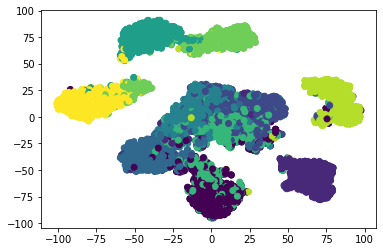

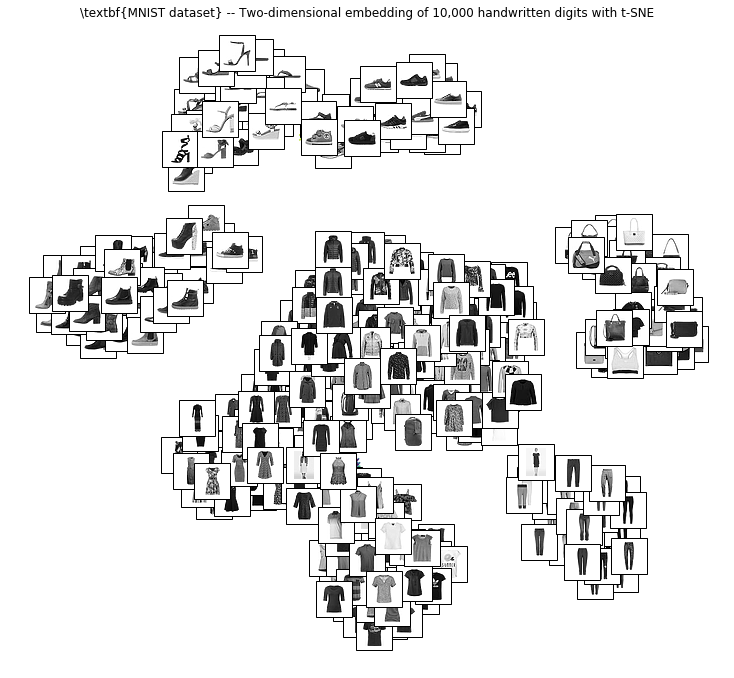

In [10]:
X_embedded = TSNE(n_components=2,perplexity=40,n_iter=2000).fit_transform(x_data)
%matplotlib
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Make point_s translucent so we can visually identify regions with a high density of overlapping points

plt.scatter(X_embedded[:,0], X_embedded[:,1],c=test_labels)
plt.show()

def plot_mnist(X, y, X_embedded, name, min_dist=10.0):
    fig = figure(figsize=(10, 10))
    ax = axes(frameon=False)
    title("\\textbf{MNIST dataset} -- Two-dimensional "
          "embedding of 10,000 handwritten digits with %s" % name)
    setp(ax, xticks=(), yticks=())
    subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=y, marker="x")

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = arange(X_embedded.shape[0])
        
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i].reshape(28, 28),
                                      cmap=cm.gray_r), X_embedded[i])
            ax.add_artist(imagebox)
plot_mnist(test_data, test_labels, X_embedded,
           "t-SNE", min_dist=20.0)

We can understand from this analysis that what might be the reason for misclassification of labels during 
calssification tasks . 
Purses do not interefere with any other class clusters and so does the trousers/pants label .
However we can observe that there is some amount of demarcation between the sandals/stilletoes and sneakers.
The shirts, dresses ,sweatshirts ,jacket labels are more often confused or prone to misclassification since the compressed representation is somewhat the same . 
P.S : The network is like men who cannot fully segregate between different apparel categories . Maybe we should try to incorporate more feminine thinking power in the networks . (Just a random thought :-P )
